In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
import theano
import theano.tensor as T
import pandas as pd
from layers import LSTMLayer, InputLayer, FullyConnectedLayer
from lib import get_params, make_caches, SGD, momentum
from basic_lstm import basicLSTM

In [148]:
def gen_impluse(stopTime, numPoints, alpha, sigma_error, p_bernoulli, irregular=False, selPoints=50):
    time = np.linspace(0, stopTime, numPoints)
    noise = np.random.normal(loc=0, scale=sigma_error, size=numPoints)
    cauchy = np.random.standard_cauchy(numPoints)
    bernoulli = np.random.binomial(1, p_bernoulli, size=numPoints)
    data = np.zeros(numPoints)
    data[0] = noise[0] + bernoulli[0]*cauchy[0]
    for i in range(1,numPoints):
        data[i] = alpha*data[i-1] + noise[i] + bernoulli[i]*cauchy[i]
    if irregular == False:
        resp_mat = np.matrix(data[1:]).T
        time_vec = time[1:]
        data_mat = np.matrix(data[:-1]).T
        return data_mat, resp_mat, time_vec
    else:
        index = np.sort(np.random.choice(range(numPoints), size=selPoints, replace=False))
        time_irr = time[index]
        data_irr = data[index]
        delta_t = [0] + list(np.array(time_irr[1:]) - np.array(time_irr[:-1]))
        derivative = np.divide(np.diff(data_irr), np.diff(time_irr))
        magDerivative = np.lib.pad(derivative, (1,0), 'constant', constant_values=(0,0))
        dDerivative = np.lib.pad(np.diff(magDerivative), (1,0), 'constant', constant_values=(0,0))
        data_mat = np.matrix([list(data_irr), delta_t, list(magDerivative), list(dDerivative)]).T
        data_mat = data_mat[:-1,:]
        resp_mat = np.matrix(np.roll(data_irr, -1)[:-1]).T
        time_vec = time_irr[1:]
        return data_mat, resp_mat, time_vec

In [110]:
stopTime = 20
numPoints = 200
sigma_error = 0.2
alpha = 1.0
p_bernoulli = 0.05
data_mat, resp_mat, time_vec = gen_impluse(stopTime, numPoints, alpha, sigma_error, p_bernoulli)

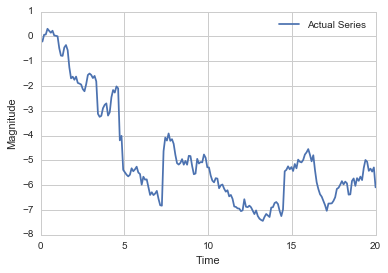

In [111]:
plt.plot(time_vec, resp_mat, label='Actual Series')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()

In [99]:
lstm_model = basicLSTM(1, num_cells=20)
numIterations = 1000

In [102]:
for i in range(numIterations):
    numSelPoints = len(data_mat)
    data_mat_tr = data_mat[:numSelPoints/3]
    resp_mat_tr = resp_mat[:numSelPoints/3]
    r_cost = lstm_model.train(data_mat_tr, resp_mat_tr, 1.0)

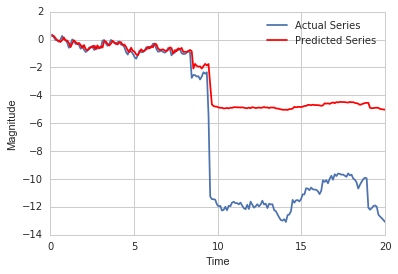

In [103]:
sns.set_style("whitegrid")
plt.plot(time_vec, resp_mat, label='Actual Series')
plt.plot(time_vec, lstm_model.predict(data_mat)[0], label='Predicted Series', color='r')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()

#### Irregular impulse time series

In [144]:
stopTime = 20
numPoints = 2000
sigma_error = 0.2
alpha = 1.0
p_bernoulli = 0.05
data_mat, resp_mat, time_vec = gen_impluse(stopTime, numPoints, alpha,\
                                           sigma_error, p_bernoulli, irregular=True, selPoints=200)

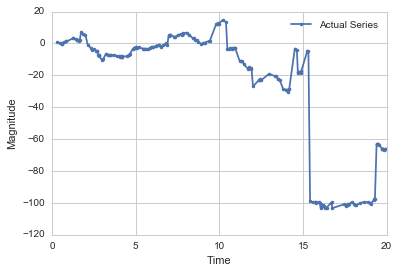

In [145]:
plt.plot(time_vec, resp_mat, marker='.', label='Actual Series')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()

In [140]:
lstm_model = basicLSTM(4, num_cells=20)
numIterations = 1000

In [141]:
for i in range(numIterations):
    numSelPoints = len(data_mat)
    data_mat_n, resp_mat_n, _ = gen_impluse(stopTime, numPoints, alpha,\
                                           sigma_error, p_bernoulli, irregular=True, selPoints=200)
    data_mat_tr = data_mat_n[:numSelPoints/2]
    resp_mat_tr = resp_mat_n[:numSelPoints/2]
    r_cost = lstm_model.train(data_mat_tr, resp_mat_tr, 1.0)

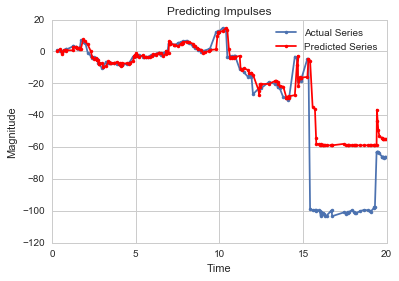

In [149]:
plt.plot(time_vec, resp_mat, marker='.', label='Actual Series')
plt.plot(time_vec, lstm_model.predict(data_mat)[0], marker='.', label='Predicted Series', color='r')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Predicting Impulses')
plt.savefig('../impulse.png')

#### Supernova dataset

In [3]:
import json

In [4]:
with open('data/1987.json') as data_file:    
    data = json.load(data_file)

In [5]:
time_series = data['SN1987A']['photometry']

In [6]:
time_series[0]

{u'band': u'V',
 u'magnitude': u'6.36',
 u'source': u'6,7',
 u'time': u'46849.44',
 u'u_time': u'MJD'}

##### Separating only one band at time 

In [151]:
mag = []
time = []
for i in range(len(time_series)):
    dict_elem = time_series[i]
    dictkeys = dict_elem.keys()
    if dict_elem[dictkeys[1]] == 'V':
        mag.append(float(dict_elem['magnitude']))
        time.append(float(dict_elem['time']))

In [152]:
def acc_vel_irregular(mag, time):
    time_irr = np.array(time) - time[0]
    data_mean = np.mean(mag)
    data_irr = np.array(mag)
    delta_t = [0] + list(np.array(time_irr[1:]) - np.array(time_irr[:-1]))
    derivative = np.divide(np.diff(data_irr), np.diff(time_irr))
    magDerivative = np.lib.pad(derivative, (1,0), 'constant', constant_values=(0,0))
    dDerivative = np.lib.pad(np.diff(magDerivative), (1,0), 'constant', constant_values=(0,0))
    data_mat = np.matrix([list(data_irr), delta_t, list(magDerivative), list(dDerivative)]).T
    data_mat = data_mat[:-1,:]
    resp_mat = np.matrix(np.roll(data_irr, -1)[:-1]).T
    time_vec = time_irr[1:]
    return data_mat, resp_mat, time_vec, data_mean

In [153]:
def basic_irr(mag, time, noise):
    time_irr = np.array(time) - time[0]
    delta_t = [0] + list(np.array(time_irr[1:]) - np.array(time_irr[:-1]))
    data_mean = np.mean(mag)
    data_irr = np.array(mag) - data_mean + np.random.normal(0,scale=noise,size=len(mag))
    data_mat = np.matrix([list(data_irr), delta_t]).T
    data_mat = data_mat[:-1,:]
    resp_mat = np.matrix(np.roll(data_irr, -1)[:-1]).T
    time_vec = time_irr[1:]
    return data_mat, resp_mat, time_vec, data_mean

In [154]:
data_mat, resp_mat, time_vec, data_mean = acc_vel_irregular(mag, time)

In [155]:
data_mat, resp_mat, time_vec, data_mean = basic_irr(mag, time, 0.001)

In [158]:
data_mat.shape

(679, 2)

In [159]:
lstm_model = basicLSTM(2, num_cells=50)
numIterations = 1000

In [160]:
numSelPoints = data_mat.shape[0]
for i in range(numIterations):
    data_mat_n, resp_mat_n, _, _ = basic_irr(mag, time, 0.2)
    data_mat_tr = data_mat_n[:numSelPoints/2]
    resp_mat_tr = resp_mat_n[:numSelPoints/2]
    r_cost = lstm_model.train(data_mat_tr, resp_mat_tr, 1.0)

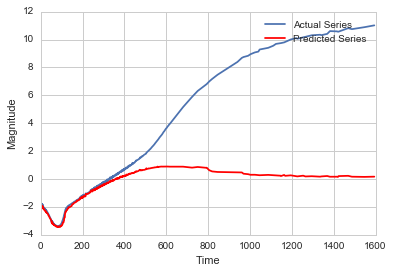

In [162]:
sns.set_style("whitegrid")
plt.plot(time_vec, resp_mat, label='Actual Series')
plt.plot(time_vec, lstm_model.predict(data_mat)[0], label='Predicted Series', color='r')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.savefig('../1987_pred.png')

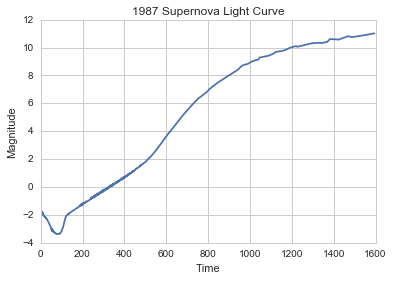

In [157]:
sns.set_style("whitegrid")
plt.plot(time_vec, resp_mat)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.title('1987 Supernova Light Curve')
plt.savefig('1987_lc.png')